#### This Code was written and kindly lent by Keith Butler (SciML group STFC)  and adapted for this course. All typos are mine :)

The aim of the tutorial is to create a classifier for two different Hamiltonians, based on inelastic neutron scattering data (INS). Don't worry too much if you have no idea what a Hamiltonian is (https://en.wikipedia.org/wiki/Hamiltonian_mechanics#Mathematical_formalism), or how inelastic neutron scattering works (https://en.wikipedia.org/wiki/Inelastic_neutron_scattering), we simply need to know that by using INS, we can indeed determine the Hamiltonian of the system we are measuring. This sort of problem is a nice example for ML, and the methodology can be applied for alot of other problems.

Jos Cooper

###############################################################################################################################
### Importing ###
###############################################################################################################################

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

# check version
print('Using TensorFlow v%s' % tf.__version__)
# Be sure that this is at least 2.0 

# helpers
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow v2.3.1


#### In our previous network we downloaded a dataset which had been rather nicely curated for us and came with its own loader. Since this is generally not the case, we need to write a data generator. The data is in an HDF5 file (these are super useful and you will see alot of them in ML), and probably can't all be loaded into memory at once, so we write something to load data in "chunks"

In [ ]:
!gdown --id 11N87FJkVhjjhhzv8cc-vwUvtZKWtHg5_
!gdown --id 1dV1ATYMwH8q93_kXR-w8JpiXEdLNclPy
data_path = '/content'

In [2]:
# define image size
IMG_HEIGHT = 20
IMG_WIDTH = 200
N_CHANNELS = 1
N_CLASSES = 2

# generator
def hdf5_generator(path, buffer_size=32):
    """ Load data INS data from disk
    
    Args:
        path: path of the HDF5 file on disk
        buffer_size: number of images to read from disk
    """
    with h5py.File(path, 'r') as handle:
        n_samples, h, w, c = handle['images'].shape
        for i in range(0, n_samples, buffer_size):
            images = handle['images'][i:i+buffer_size, ..., :1]
            labels = handle['labels'][i:i+buffer_size]
            yield images, labels

# training data
train_dataset = tf.data.Dataset.from_generator(lambda: hdf5_generator(path=data_path + '/train.h5'), 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), 
                                                              (None, N_CLASSES,)))

# test data
test_dataset = tf.data.Dataset.from_generator(lambda: hdf5_generator(path=data_path + '/test.h5'), 
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), 
                                                             (None, N_CLASSES,)))
# print
print(train_dataset)
print(test_dataset)

<FlatMapDataset shapes: ((None, 20, 200, 1), (None, 2)), types: (tf.float32, tf.float32)>
<FlatMapDataset shapes: ((None, 20, 200, 1), (None, 2)), types: (tf.float32, tf.float32)>


1.0


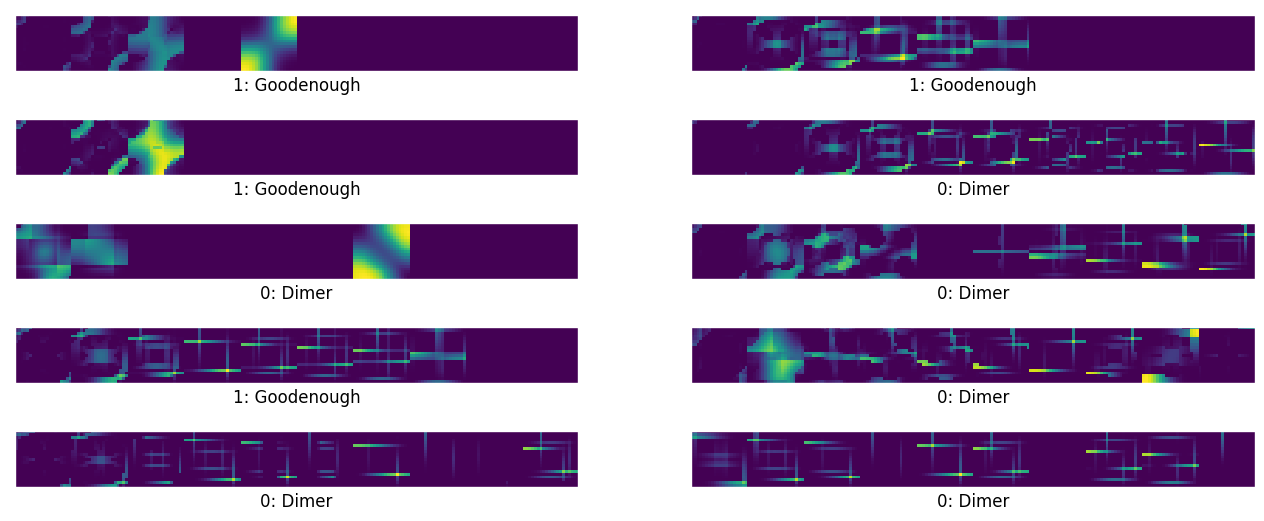

In [6]:
# load the first buffer (with 32 data by default)
images, labels = list(test_dataset.take(1))[0]
print(np.max(images[0]))
# plot some images and labels from it
nplot = 10
fig, axes = plt.subplots(nplot // 2, 2, figsize=(16, nplot / 1.5), dpi=100)
for ax, image, label in zip(axes.flatten(), images, labels):
    #print(image[1].numpy)
    ax.matshow(image[:,:,0])
    ax.set_xlabel('0: Dimer' if label[0] < .5 else '1: Goodenough', c='k')
    ax.set_xticks([])
    ax.set_yticks([])


### Task:

1. Make a network which takes in the images, flattens them and then has two dense layers with 16 then 8 nodes. The final layer should use a sigmoid to classify the output into one of the two classes.

2. Compile the model using ADAM and a binary corss entropy loss. Use accuracy as a metric and add some additional metrics to measure:
keras.metrics.TruePositives(name='true_positives'),
keras.metrics.FalsePositives(name='false_positives'),
keras.metrics.TrueNegatives(name='true_negatives'),
keras.metrics.FalseNegatives(name='false_negatives')

3. Train the model for 10 epochs and examine the accuracy and loss of both the training and the validation datasets.

4. Improve on this model



In [7]:
# network architecture
model = Sequential()
model.add(Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(N_CLASSES, activation='sigmoid'))

# print summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4000)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                64016     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 64,170
Trainable params: 64,170
Non-trainable params: 0
_________________________________________________________________


In [8]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics= ['accuracy',
                        keras.metrics.TruePositives(name='true_positives'),
                        keras.metrics.FalsePositives(name='false_positives'),
                        keras.metrics.TrueNegatives(name='true_negatives'),
                        keras.metrics.FalseNegatives(name='false_negatives')])

In [9]:
# train the model
training_history = model.fit(train_dataset, validation_data=test_dataset, 
                             epochs=10)

Epoch 1/10
625/625 [==============================] - 6s 9ms/step - loss: 0.5128 - accuracy: 0.7395 - true_positives: 15420.0000 - false_positives: 6068.0000 - true_negatives: 13932.0000 - false_negatives: 4580.0000 - val_loss: 0.3332 - val_accuracy: 0.8824 - val_true_positives: 5932.0000 - val_false_positives: 871.0000 - val_true_negatives: 5805.0000 - val_false_negatives: 744.0000
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1849 - accuracy: 0.9413 - true_positives: 18855.0000 - false_positives: 1272.0000 - true_negatives: 18728.0000 - false_negatives: 1145.0000 - val_loss: 0.1106 - val_accuracy: 0.9648 - val_true_positives: 6441.0000 - val_false_positives: 242.0000 - val_true_negatives: 6434.0000 - val_false_negatives: 235.0000
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0958 - accuracy: 0.9680 - true_positives: 19366.0000 - false_positives: 664.0000 - true_negatives: 19336.0000 - false_negatives: 634.0000 - val_loss: 0.

In [10]:
# print final values of metrics for validation data
print('Right for Dimer: %d' % training_history.history['val_true_positives'][-1])
print('Wrong for Dimer: %d' % training_history.history['val_false_positives'][-1])
print('Right for Goodenough: %d' % training_history.history['val_true_negatives'][-1])
print('Wrong for Goodenough: %d' % training_history.history['val_false_negatives'][-1])

Right for Dimer: 6551
Wrong for Dimer: 119
Right for Goodenough: 6557
Wrong for Goodenough: 125


In [11]:
training_history.history.keys()

dict_keys(['loss', 'accuracy', 'true_positives', 'false_positives', 'true_negatives', 'false_negatives', 'val_loss', 'val_accuracy', 'val_true_positives', 'val_false_positives', 'val_true_negatives', 'val_false_negatives'])

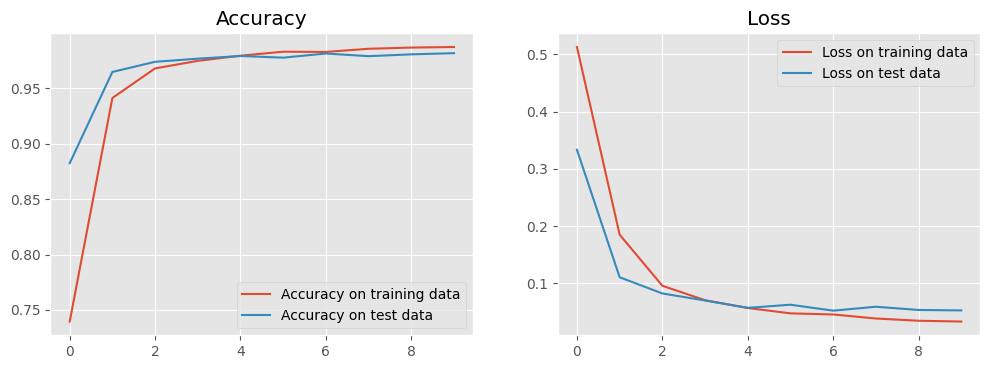

In [12]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Accuracy on training data')
plt.plot(training_history.history['val_accuracy'], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()